Neo4J v053 Test2
================

## Set up the environment


### Install py2neo for querying Neo4J 

In [155]:
#!pip3 install py2neo

### Import Packages

In [156]:
from py2neo import Graph
import pandas as pd
import numpy as np
import subprocess
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.f' % x)

### Load Neo4J DB

In [157]:
graph = Graph("bolt://35.230.80.57:7687", auth=("neo4j", "bZjcc1XTd71ft2oVGj7A8aU8UkttdBhRAecV4x6USC3wpeOLmCmfCAH2bAMllQQlwtzCbzLuX1TgoX-Enc7MUA"))

## Count inputs and outputs

### Sample Count by Plate

In [158]:
query = "MATCH (n:Fastq) WITH n.sample AS sample, n.plate AS plate RETURN plate, count(distinct sample) AS count"
samples_plate = graph.run(query).to_data_frame()

columnlist=["plate","count"]
samples_plate=samples_plate[columnlist]

n_sample = samples_plate['count'].sum()
n_plate = len(samples_plate['plate'])

print('The number of plates : ' + str(n_plate))
print('The number of samples : ' + str(n_sample))

## Display the number of samples by plate
#samples_plate

Failed to write data to connection ('35.230.80.57', 7687) (Address(host='35.230.80.57', port=7687)); ("104; 'Connection reset by peer'")


The number of plates : 14
The number of samples : 1330


### Node Count (Fastq, Ubam, Cram, Crai, Vcf)

In [159]:
result = {"label": [], "count": [], "samples": []}
nodelist = ["Json:FromPersonalis", "Fastq", "Ubam", "Cram", "Crai", "Merged:Vcf"]

for label in nodelist:
    query1 = "MATCH (n:{}) RETURN count(n) as count".format(label)
    count = graph.run(query1).to_data_frame().iloc[0]['count']
    query2 = "MATCH (n:{}) RETURN count(distinct n.sample) as samples".format(label)
    samples = graph.run(query2).to_data_frame().iloc[0]['samples']
    result["label"].append(label)
    result["count"].append(count)
    result["samples"].append(samples)
    
nodes_df=pd.DataFrame(data=result)
nodes_df['expected']=[n_sample, nodes_df['count'][1], nodes_df['count'][1]/2, n_sample, n_sample, n_sample]
#nodes_df['missed']=nodes_df['expected']-nodes_df['count']
#nodes_df['successful_rate'] = (nodes_df['expected']-nodes_df['samples'])

n_fastq = nodes_df['count'][1]
n_ubam = nodes_df['count'][2]
n_cram = nodes_df['count'][3]
n_crai = nodes_df['count'][4]
n_vcf = nodes_df['count'][5]

# # Display
# print('The number of fastqs : ' + str(n_fastq))
# print('The number of ubams : ' + str(n_ubam))
# print('The number of crams : ' + str(n_cram))
# print('The number of crais : ' + str(n_crai))
# print('The number of vcfs : ' + str(n_vcf))

# Display
columnlist=["label","expected","count","samples"]
nodes_df=nodes_df[columnlist]
nodes_df

,label,expected,count,samples
0,Json:FromPersonalis,1330,1330,1330
1,Fastq,10546,10546,1330
2,Ubam,5273,5259,1330
3,Cram,1330,1312,1309
4,Crai,1330,1313,1309
5,Merged:Vcf,1330,1309,1308


### Distribution of the number of Fastq of per sample

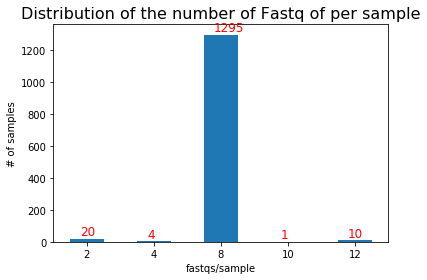

In [160]:
query = "MATCH (n:Fastq) WITH n.sample as sample, n.plate as plate, COLLECT(n) AS fastqs RETURN size(fastqs) as fastq_num, sample, plate"
fastqs_df = graph.run(query).to_data_frame()
fastqs_dist=fastqs_df.groupby(['fastq_num']).count().reset_index()

# Figure
fastqs_dist.plot(kind='bar', x='fastq_num', y='sample', legend=None)
plt.yscale("linear")
plt.title("Distribution of the number of Fastq of per sample",fontsize=16)
plt.xlabel("fastqs/sample")
plt.ylabel("# of samples")
plt.xticks(rotation=0)

label_ypos=fastqs_dist["sample"]+20

for i in range(len(fastqs_dist['fastq_num'])):
    plt.text(x = i-0.1, y =label_ypos[i], s =fastqs_dist["sample"][i], size = 12, color = 'r')
plt.show()

## Check : Fastq to Ubam

### Successful Rate of Fastq-to-Ubam
with output(ubam) point-of-view

#### Successful / Failed Fastqs

In [161]:
query = "MATCH (n:Fastq) WHERE ((n)-[*]->(:Job:Dsub {name:'fastq-to-ubam'})-[*]->(:Ubam)) RETURN count(n)"
fastqs_toubam = graph.run(query).to_series()
print("The number of fastqs successfully converted to Ubam: " + str(fastqs_toubam[0]))

query = "MATCH (n:Fastq) WHERE not (n)-[*]->(:Job:Dsub {name:'fastq-to-ubam'})-[*]->(:Ubam) RETURN count(n)"
fastqs_missedubam = graph.run(query).to_series()
print("The number of fastqs missed Ubam : " + str(fastqs_missedubam[0]))

query = "MATCH (n:Fastq) WHERE not (n)-[*]->(:Job:Dsub {name:'fastq-to-ubam'})-[*]->(:Ubam) RETURN count(distinct n.sample)"
samples_missedubam = graph.run(query).to_series()


print("The number of samples successfully converted to Ubam : " + str(n_sample-samples_missedubam[0]))
print("The number of samples missed Ubam : " + str(samples_missedubam[0]))
print("\n")
print("The successful rate of Fastq-to-Ubam (fastq base) : " + str(100*(fastqs_toubam[0]/n_fastq)) + "%")
print("The successful rate of Fastq-to-Ubam (sample base) : " + str(100*((n_sample-samples_missedubam[0])/n_sample)) + "%")

The number of fastqs successfully converted to Ubam: 10510
The number of fastqs missed Ubam : 36
The number of samples successfully converted to Ubam : 1312
The number of samples missed Ubam : 18


The successful rate of Fastq-to-Ubam (fastq base) : 99.65863834629243%
The successful rate of Fastq-to-Ubam (sample base) : 98.64661654135338%


#### Job-related ubams / Duplicated ubams

In [192]:
query1 = "MATCH (u:Ubam) WHERE not (:Job:Dsub {name:'fastq-to-ubam'})-[:OUTPUT]->(u) RETURN u.basename"
onlyubam = graph.run(query1).to_series()
print("The number of ubam without job information: " + str(len(onlyubam)))

query2 = "MATCH (u:Ubam) WHERE (:Job:Dsub {name:'fastq-to-ubam'})-[:OUTPUT]->(u) RETURN u.basename"
ubamwithjob = graph.run(query2).to_series()
print("The number of ubam with job information: " + str(len(ubamwithjob)))

query3 = "MATCH (u:Ubam) RETURN distinct u.basename AS ubam, count(u.basename) AS cnt"
duplicatedubam = graph.run(query3).to_data_frame()
duplicatedubam[duplicatedubam['cnt']>1]
#print("The number of ubam without job information: " + str(len(onlyubam)))


The number of ubam without job information: 4
The number of ubam with job information: 5255


,cnt,ubam
958,2,SHIP5119429_2.ubam


### Failed Fastq list, File Size

Input point-of-view (Fastq)

#### Failed Fastq list


In [162]:
query = "MATCH (n:Fastq) WHERE not (n)-[*]->(:Job:Dsub {name:'fastq-to-ubam'})-[*]->(:Ubam) RETURN n.basename as basename, n.sample as sample"
fastqs_missedubam_list = graph.run(query).to_data_frame()
#fastqs_missedubam_list.sort_values('sample')

#sample_missedubam = fastqs_missedubam_list.groupby(['sample']).count()
#sample_missedubam

#### Histogram of Fastq file size


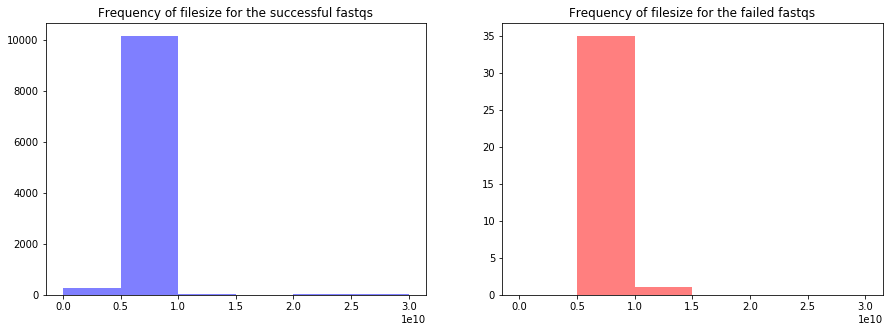

In [163]:
query1 = "MATCH (n:Fastq) WHERE (n)-[*]->(:Job:Dsub {name:'fastq-to-ubam'})-[*]->(:Ubam) RETURN n.basename as basename, n.sample as sample, n.size as size"
successful_fastqs_filesize = graph.run(query1).to_data_frame()

query2 = "MATCH (n:Fastq) WHERE not (n)-[*]->(:Job:Dsub {name:'fastq-to-ubam'})-[*]->(:Ubam) RETURN n.basename as basename, n.sample as sample, n.size as size"
failed_fastqs_filesize = graph.run(query2).to_data_frame()

fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(121)
ax1.hist(successful_fastqs_filesize['size'], bins=[0,5e9,10e9,15e9,20e9,25e9,30e9], color='blue', alpha = 0.5)
ax1.set_title('Frequency of filesize for the successful fastqs')
ax2=fig.add_subplot(122)
ax2.hist(failed_fastqs_filesize['size'],[0,5e9,10e9,15e9,20e9,25e9,30e9],color='red', alpha = 0.5)
ax2.set_title('Frequency of filesize for the failed fastqs')
plt.show()

### Running Time

Job point-of-view (FastqTobam)
- included duplcated jobs

#### FastqtoUbam Jobs

In [220]:
query = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WITH j.sample AS Sample, j.dsubJobId AS FastqToUbamID, j.input_FASTQ_1 AS FASTQ1, j.input_FASTQ_2 AS FASTQ2, j.durationMinutes AS FastqToUbamRuntime RETURN FastqToUbamID, Sample, FastqToUbamRuntime, FASTQ1, FASTQ2"
total_fastqs = graph.run(query).to_data_frame()

print("The number of total FastqtoUbam jobs : " + str(len(total_fastqs)))
total_fastqs.head(3)

## duplcation check 
if len(total_fastqs) == len(total_fastqs['FASTQ1'].unique()):
    print("Check duplication of FastqToUbam : " + " No duplcated job")
else:
    t_count=total_fastqs.groupby(['FASTQ1']).count().reset_index()
    print("The list of fastqs in duplicated jobs \n")
    print("The number of duplicated jobs : " + str(len(t_count.loc[t_count.FastqToUbamID > 1,:])))
    #print(t_count.loc[t_count.FastqToUbamID > 1,'FASTQ1'])

The number of total FastqtoUbam jobs : 5317
The list of fastqs in duplicated jobs 

The number of duplicated jobs : 44


#### Successful FastqtoUbam Jobs

In [221]:
query = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WHERE (j)-[:OUTPUT]->(:Ubam) WITH j.sample AS Sample, j.dsubJobId AS FastqToUbamID, j.input_FASTQ_1 AS FASTQ1, j.input_FASTQ_2 AS FASTQ2, j.durationMinutes AS FastqToUbamRuntime RETURN FastqToUbamID, Sample, FastqToUbamRuntime, FASTQ1, FASTQ2"
successful_fastqs = graph.run(query).to_data_frame()

print("The number of successful FastqtoUbam jobs : " + str(len(successful_fastqs)))
successful_fastqs.head(3)

## duplcation check 
if len(successful_fastqs) == len(successful_fastqs['FASTQ1'].unique()):
    print("Check duplication of FastqToUbam : " + " No duplcated job")
else:
    s_count=successful_fastqs.groupby(['FASTQ1']).count().reset_index()
    print("The number of duplicated jobs : " + str(len(s_count.loc[t_count.FastqToUbamID > 1,:])))
    print("The list of fastqs in duplicated jobs \n")
    print(s_count.loc[s_count.FastqToUbamID > 1,'FASTQ1'])

The number of successful FastqtoUbam jobs : 5255
Check duplication of FastqToUbam :  No duplcated job


#### Failed FastqtoUbam Jobs

In [222]:
query = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WHERE not (j)-[:OUTPUT]->(:Ubam) WITH j.sample AS Sample, j.dsubJobId AS FastqToUbamID, \
j.input_FASTQ_1 AS FASTQ1, j.input_FASTQ_2 AS FASTQ2, j.durationMinutes AS FastqToUbamRuntime, j.logging AS log \
RETURN FastqToUbamID, Sample, FastqToUbamRuntime, FASTQ1, FASTQ2, log"
failed_fastqs = graph.run(query).to_data_frame()

print("The number of failed FastqtoUbam jobs : " + str(len(failed_fastqs)))
failed_fastqs.head(3)

## duplcation check 
if len(failed_fastqs) == len(failed_fastqs['FASTQ1'].unique()):
    print("Check duplication of FastqToUbam : " + " No duplcated job")
else:
    f_count=failed_fastqs.groupby(['FASTQ1']).count().reset_index()
    print("The number of duplicated jobs : " + str(len(f_count.loc[t_count.FastqToUbamID > 1,:])))
    print("The list of fastqs in duplicated jobs \n")
    print(f_count.loc[f_count.FastqToUbamID > 1,'FASTQ1'])

The number of failed FastqtoUbam jobs : 62
Check duplication of FastqToUbam :  No duplcated job


#### Histogram of Running Time

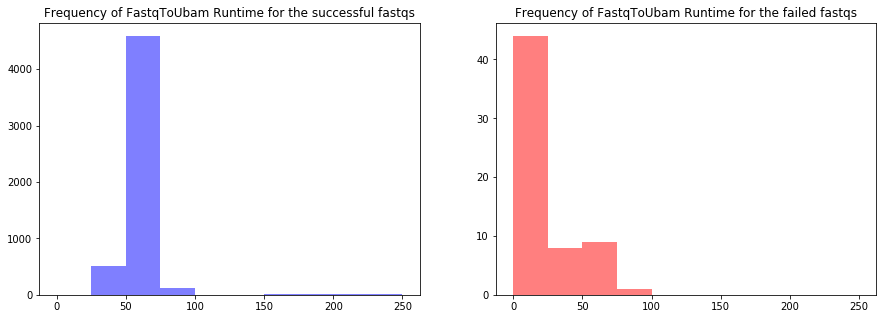

In [167]:
fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(121)
ax1.hist(successful_fastqs['FastqToUbamRuntime'],bins=[0,25,50,75,100,150,200,250],color='blue', alpha = 0.5)
ax1.set_title('Frequency of FastqToUbam Runtime for the successful fastqs')
ax2=fig.add_subplot(122)
ax2.hist(failed_fastqs['FastqToUbamRuntime'],bins=[0,25,50,75,100,150,200,250],color='red', alpha = 0.5)
ax2.set_title('Frequency of FastqToUbam Runtime for the failed fastqs')
plt.show()

### Log file analysis (Failed FastqtoUbam Jobs)

#### The number of log files

In [178]:
failedloglist=list(failed_fastqs['log'])
f = open("./failed_FQ2U_log_v053.txt", 'w')
missinglog = 0 
for i in failedloglist:
    try:
        output = str(subprocess.check_output('gsutil ls ' + i, shell=True),'utf-8')
        f.write(output)
    except:
        missinglog += 1
        f.write("Unexpected error:" + i +'\n')
f.close()

print("The number of log of failed jobs : " + str(len(failedloglist)))
print("The number of failed jobs missing log files : " + str(missinglog))

The number of log of failed jobs : 62
The number of failed jobs missing log files : 31


#### Log file Analysis

In [179]:
fulllog = pd.read_csv('./failed_FQ2U_log_v053.txt', header=None)
donelog = 0
for i in fulllog[0]:
    if 'stderr' in i:
        try:
            display(i)
            donelog += 1
            display(str(subprocess.check_output('gsutil cat ' + i + '| grep "done"', shell=True),'utf-8'))
        except:
            continue
print("The number of failed jobs with 'done' : " + str(donelog))

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000432/SHIP5119430/fastq-to-ubam/190923-210052-214-338fde07/logs/fq2u-338fd--trellis--190923-210052-48-stderr.log'

'[Mon Sep 23 21:45:28 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 39.57 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000432/SHIP5119443/fastq-to-ubam/190923-210159-275-0a670108/logs/fq2u-0a670--trellis--190923-210159-67-stderr.log'

'[Mon Sep 23 21:44:48 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 37.88 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000444/SHIP5141860/fastq-to-ubam/190923-210233-506-d0e1bafa/logs/fq2u-d0e1b--trellis--190923-210234-07-stderr.log'

'[Mon Sep 23 22:22:37 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 71.52 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000450/SHIP5142426/fastq-to-ubam/190923-210257-282-d99f9023/logs/fq2u-d99f9--trellis--190923-210258-00-stderr.log'

'[Mon Sep 23 21:49:44 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 41.76 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000452/SHIP5142623/fastq-to-ubam/190923-214123-110-14c9d42d/logs/fq2u-14c9d--trellis--190923-214123-38-stderr.log'

'[Mon Sep 23 22:30:31 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 43.33 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000452/SHIP5132721/fastq-to-ubam/190923-214247-191-ec0be248/logs/fq2u-ec0be--trellis--190923-214247-49-stderr.log'

'[Mon Sep 23 22:33:27 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 42.87 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000453/SHIP5153233/fastq-to-ubam/190923-214627-196-5e21babc/logs/fq2u-5e21b--trellis--190923-214627-71-stderr.log'

'[Mon Sep 23 22:38:22 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 46.21 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000454/SHIP5153310/fastq-to-ubam/190924-000414-416-d5839493/logs/fq2u-d5839--trellis--190924-000414-77-stderr.log'

'[Tue Sep 24 01:00:48 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 49.18 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000456/SHIP5183667/fastq-to-ubam/190924-000513-352-f8904474/logs/fq2u-f8904--trellis--190924-000513-78-stderr.log'

'[Tue Sep 24 00:54:24 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 43.61 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000456/SHIP5183694/fastq-to-ubam/190924-000616-625-be6cf900/logs/fq2u-be6cf--trellis--190924-000617-20-stderr.log'

'[Tue Sep 24 01:23:53 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 42.51 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000459/SHIP5165713/fastq-to-ubam/190924-004036-683-91ee56b6/logs/fq2u-91ee5--trellis--190924-004037-07-stderr.log'

'[Tue Sep 24 01:43:37 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 43.33 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000463/SHIP5169507/fastq-to-ubam/190924-004516-782-038398a0/logs/fq2u-03839--trellis--190924-004517-08-stderr.log'

'[Tue Sep 24 01:35:08 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 43.54 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000461/SHIP5169315/fastq-to-ubam/190924-004607-067-b8598714/logs/fq2u-b8598--trellis--190924-004607-47-stderr.log'

'[Tue Sep 24 01:41:45 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 35.80 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000463/SHIP5169487/fastq-to-ubam/190924-004632-684-48378cc0/logs/fq2u-48378--trellis--190924-004633-20-stderr.log'

'[Tue Sep 24 01:55:40 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 48.09 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000463/SHIP5169480/fastq-to-ubam/190924-004645-491-23d9cc4f/logs/fq2u-23d9c--trellis--190924-004646-08-stderr.log'

'[Tue Sep 24 02:18:25 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 55.08 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000465/SHIP5185334/fastq-to-ubam/190924-030532-808-ce6b43f9/logs/fq2u-ce6b4--trellis--190924-030533-09-stderr.log'

'[Tue Sep 24 04:35:20 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 39.72 minutes.\n'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000465/SHIP5185260/fastq-to-ubam/190924-030530-364-df546919/logs/fq2u-df546--trellis--190924-030530-76-stderr.log'

'[Tue Sep 24 04:23:38 UTC 2019] picard.sam.FastqToSam done. Elapsed time: 42.62 minutes.\n'

The number of failed jobs with 'done' : 17


### Dstat Messange

#### Job and Dstat connection check

In [234]:
query1 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WHERE (j)-[:OUTPUT]->(:Ubam) and (j)-[:STATUS]->(:Dstat) RETURN count(j)"
dstat_fq2u_yes = graph.run(query1).to_series()
print("The number of successful fastq-to-ubam jobs with dstat information : " + str(dstat_fq2u_yes[0]))

query2 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WHERE (j)-[:OUTPUT]->(:Ubam) and not (j)-[:STATUS]->(:Dstat) RETURN count(j)"
dstat_fq2u_no = graph.run(query2).to_series()
print("The number of successful fastq-to-ubam jobs without dstat information : " + str(dstat_fq2u_no[0]))

query3 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WHERE not (j)-[:OUTPUT]->(:Ubam) and (j)-[:STATUS]->(:Dstat) RETURN count(j)"
dstat_fq2ux_yes = graph.run(query3).to_series()
print("The number of failed fastq-to-ubam jobs with dstat information : " + str(dstat_fq2ux_yes[0]))

query4 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WHERE not (j)-[:OUTPUT]->(:Ubam) and not (j)-[:STATUS]->(:Dstat) RETURN count(j)"
dstat_fq2ux_no = graph.run(query4).to_series()
print("The number of failed fastq-to-ubam jobs with dstat information : " + str(dstat_fq2ux_no[0]))

The number of successful fastq-to-ubam jobs with dstat information : 5246
The number of successful fastq-to-ubam jobs without dstat information : 9
The number of failed fastq-to-ubam jobs with dstat information : 62
The number of failed fastq-to-ubam jobs with dstat information : 0


#### Job and Dstat information miss-matched cases

In [242]:
query1 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'})-[:STATUS]->(s:Dstat) WHERE (j)-[:OUTPUT]->(:Ubam) AND not s.status = 'SUCCESS' RETURN distinct s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dstat_fq2u_yes_df = graph.run(query1).to_data_frame()
display(dstat_fq2u_yes_df)

query3 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'})-[:STATUS]->(s:Dstat) WHERE not (j)-[:OUTPUT]->(:Ubam) AND s.status = 'SUCCESS' RETURN distinct s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dstat_fq2ux_yes_df = graph.run(query3).to_data_frame()
display(dstat_fq2ux_yes_df)

query33 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'})-[:STATUS]->(s:Dstat) WHERE not (j)-[:OUTPUT]->(:Ubam) AND not s.status = 'SUCCESS' RETURN distinct s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dstat_fq2ux_yes_df3 = graph.run(query33).to_data_frame()
display(dstat_fq2ux_yes_df3)

,DstatId,Message,log,status
0,fq2u-c4bbd--trellis--190924-004655-08,ServiceException: 401 Anonymous caller does no...,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE
1,fq2u-dbced--trellis--190924-000633-25,ServiceException: 401 Anonymous caller does no...,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE
2,fq2u-72580--trellis--190924-004606-89,ServiceException: 401 Anonymous caller does no...,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE


,DstatId,Message,log,status
0,fq2u-338fd--trellis--190923-210052-48,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,SUCCESS
1,fq2u-d5839--trellis--190924-000414-77,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,SUCCESS
2,fq2u-df546--trellis--190924-030530-76,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,SUCCESS


,DstatId,Message,log,status
0,fq2u-5ede9--trellis--190923-210130-58,Stopped running 'prepare',gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
1,fq2u-5ede9--trellis--190923-210130-58,Worker 'google-pipelines-worker-6b640db5e96c87...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
2,fq2u-b64e2--trellis--190923-210131-58,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE
3,fq2u-b8b6b--trellis--190923-210156-77,worker was terminated,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE
4,fq2u-0a670--trellis--190923-210159-67,to gbsc-gcp-project-mvp-test-from-personalis-...,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE
...,...,...,...,...
59,fq2u-fefe6--trellis--190924-034023-98,Stopped pulling 'gcr.io/gbsc-gcp-project-mvp-t...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
60,fq2u-f96ac--trellis--190924-034022-99,Stopped pulling 'gcr.io/gbsc-gcp-project-mvp-t...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
61,fq2u-5374c--trellis--190924-034024-96,Started running 'localization',gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
62,fq2u-8d86b--trellis--190924-034029-83,Stopped pulling 'gcr.io/gbsc-gcp-project-mvp-t...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING


#### Job and Dstat duplication issue check

In [248]:
query1 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'})-[:STATUS]->(s:Dstat) WHERE (j)-[:OUTPUT]->(:Ubam) and s.jobName STARTS WITH 'fq2u' RETURN j.dsubJobId AS FastqToUbamID, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dstat_fq2u_df = graph.run(query1).to_data_frame()

query2 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'})-[:STATUS]->(s:Dstat) WHERE (j)-[:OUTPUT]->(:Ubam) and s.jobName STARTS WITH 'fq2u' RETURN distinct j.dsubJobId AS FastqToUbamID, count(s.jobId) AS cnt" #, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dup_dstat_fq2u_df = graph.run(query2).to_data_frame()
dup=dup_dstat_fq2u_df[dup_dstat_fq2u_df['cnt']>1]

dstat_fq2u_df[dstat_fq2u_df['FastqToUbamID'].isin(dup['FastqToUbamID'])]

,DstatId,FastqToUbamID,Message,log,status
12,fq2u-0058d--trellis--190923-210056-80,fq2u-0058d--trellis--190923-210056-80,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,SUCCESS
13,fq2u-0058d--trellis--190923-210056-80,fq2u-0058d--trellis--190923-210056-80,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,SUCCESS
15,fq2u-0058d--trellis--190923-210056-80,fq2u-0058d--trellis--190923-210056-80,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,SUCCESS
2318,fq2u-4a0b8--trellis--190924-000034-38,fq2u-4a0b8--trellis--190924-000034-38,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,SUCCESS
2319,fq2u-4a0b8--trellis--190924-000034-38,fq2u-4a0b8--trellis--190924-000034-38,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...,SUCCESS


In [249]:
query3 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'})-[:STATUS]->(s:Dstat) WHERE not (j)-[:OUTPUT]->(:Ubam) and s.jobName STARTS WITH 'fq2u' RETURN j.dsubJobId AS FastqToUbamID, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
#query = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WHERE (j)-[:OUTPUT]->(:Ubam) and (j)-[:STATUS]->(:Dstat) RETURN j.taskId AS FastqToUbamID, j.input_FASTQ_1 AS FASTQ1"
dstat_fq2u_df = graph.run(query3).to_data_frame()

query4 = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'})-[:STATUS]->(s:Dstat) WHERE not (j)-[:OUTPUT]->(:Ubam) and s.jobName STARTS WITH 'fq2u' RETURN j.dsubJobId AS FastqToUbamID, count(s.jobId) AS cnt" #, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
#query = "MATCH (j:Job:Dsub {name:'fastq-to-ubam'}) WHERE (j)-[:OUTPUT]->(:Ubam) and (j)-[:STATUS]->(:Dstat) RETURN j.taskId AS FastqToUbamID, j.input_FASTQ_1 AS FASTQ1"
dup_dstat_fq2u_df = graph.run(query4).to_data_frame()
dup=dup_dstat_fq2u_df[dup_dstat_fq2u_df['cnt']>1]

display(dstat_fq2u_df[dstat_fq2u_df['FastqToUbamID'].isin(dup['FastqToUbamID'])])

,DstatId,FastqToUbamID,Message,log,status
0,fq2u-5ede9--trellis--190923-210130-58,fq2u-5ede9--trellis--190923-210130-58,Worker 'google-pipelines-worker-6b640db5e96c87...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
9,fq2u-5ede9--trellis--190923-210130-58,fq2u-5ede9--trellis--190923-210130-58,Stopped running 'prepare',gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
10,fq2u-64f29--trellis--190923-210244-77,fq2u-64f29--trellis--190923-210244-77,Worker 'google-pipelines-worker-115ef3db30e81d...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
12,fq2u-fd69a--trellis--190923-210254-77,fq2u-fd69a--trellis--190923-210254-77,Worker 'google-pipelines-worker-c30f07ea065aeb...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
13,fq2u-64f29--trellis--190923-210244-77,fq2u-64f29--trellis--190923-210244-77,Started running 'localization',gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
14,fq2u-fd69a--trellis--190923-210254-77,fq2u-fd69a--trellis--190923-210254-77,Started pulling 'gcr.io/gbsc-gcp-project-mvp-t...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
22,fq2u-519d6--trellis--190923-220104-98,fq2u-519d6--trellis--190923-220104-98,Worker 'google-pipelines-worker-882a96720b3991...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
23,fq2u-519d6--trellis--190923-220104-98,fq2u-519d6--trellis--190923-220104-98,Started pulling 'gcr.io/gbsc-gcp-project-mvp-t...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
42,fq2u-e0ce4--trellis--190924-034025-18,fq2u-e0ce4--trellis--190924-034025-18,Worker 'google-pipelines-worker-db80acc6901b7f...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
52,fq2u-e0ce4--trellis--190924-034025-18,fq2u-e0ce4--trellis--190924-034025-18,Started pulling 'gcr.io/gbsc-gcp-project-mvp-t...,gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING


#### Copy issued file log to other back-up folder

In [95]:
#for i in unique_dstat_fq2u_df['log']:
#    subprocess.check_output('gsutil cp ' + i + ' gs://gbsc-gcp-project-mvp-test_user-jinasong/wgs35-logs-v053/fq2u-failed/', shell=True)

## Ubam for GATK

#### The number of ubams possilbe to join in GATK

In [286]:
query1 = "MATCH (n:Ubam) WITH n.sample as sample, n.setSize as setSize, COLLECT(n) AS ubams WHERE size(ubams) >= setSize UNWIND ubams as ubam_id RETURN count(distinct sample) AS numofSamplesforGATK, count(ubam_id) AS numofUbamsforGATK"
ubam_gatk_df = graph.run(query1).to_data_frame()
display(ubam_gatk_df)

query2 = "MATCH (n:Ubam) WITH n.sample as sample, n.setSize as setSize, COLLECT(n) AS ubams WHERE size(ubams) >= setSize UNWIND ubams as ubam_id RETURN sample AS sample"
samplelist_gatk_df = graph.run(query2).to_data_frame()

,numofSamplesforGATK,numofUbamsforGATK
0,1315,5214


#### Ubam fie size distribution

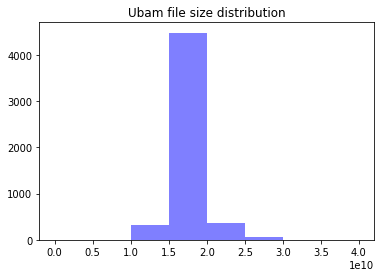

In [257]:
query = "MATCH (n:Ubam) RETURN n.size AS size"
ubam_size_df = graph.run(query).to_data_frame()

plt.hist(ubam_size_df['size'],bins=[0,5e9,10e9,15e9,20e9,25e9,30e9,35e9,40e9], color='blue', alpha = 0.5)
plt.xticks([0,5e9,10e9,15e9,20e9,25e9,30e9,35e9,40e9])
plt.title('Ubam file size distribution')
plt.show()

## CHECK : $5 GATK

### $5 GATK - VCF

#### The number of VCFs and duplicated VCFs

In [266]:
query1 = "MATCH (n:Merged:Vcf) WITH n.sample as sample RETURN sample"
samplelist_vcf_df = graph.run(query1).to_data_frame()

query2 = "MATCH (n:Merged:Vcf) WITH n.sample as sample RETURN distinct sample"
unique_samplelist_vcf_df = graph.run(query2).to_data_frame()

print("The number of unique vcf files : " + str(len(unique_samplelist_vcf_df)))
print("The number of duplicated vcf files : " + str(len(samplelist_vcf_df)-len(unique_samplelist_vcf_df)))

query3 = "MATCH (n:Merged:Vcf) WITH n.sample as nsample RETURN distinct nsample AS sample, count(nsample) AS cnt" #, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dup_vcf_df = graph.run(query3).to_data_frame()
dup=dup_vcf_df[dup_vcf_df['cnt']>1]

samplelist_vcf_df[samplelist_vcf_df['sample'].isin(dup['sample'])]

The number of unique vcf files : 1308
The number of duplicated vcf files : 1


,sample
1295,SHIP5185330
1297,SHIP5185330


#### The missed VCFs

In [291]:
query = " \
MATCH (n:Ubam) WITH n.sample as sample, n.setSize as setSize, COLLECT(n) AS ubams WHERE size(ubams) >= setSize UNWIND ubams as ubam_gatk \
WITH ubam_gatk \
WHERE not (ubam_gatk)-[*]->(:Vcf) \
RETURN count(ubam_gatk) AS numofUbams_missedVCF, count(distinct ubam_gatk.sample) AS numofSamples_missedVCF \
"
ubams_missedVCF = graph.run(query).to_data_frame()
ubams_missedVCF

### $5 GATK - CRAM

#### The number of CRAMs and duplicated CRAMs

In [268]:
query1 = "MATCH (n:Cram) WITH n.sample as sample RETURN sample"
samplelist_cram_df = graph.run(query1).to_data_frame()

query2 = "MATCH (n:Cram) WITH n.sample as sample RETURN distinct sample"
unique_samplelist_cram_df = graph.run(query2).to_data_frame()

print("The number of unique cram files : " + str(len(unique_samplelist_cram_df)))
print("The number of duplicated cram files : " + str(len(samplelist_cram_df)-len(unique_samplelist_cram_df)))

query3 = "MATCH (n:Cram) WITH n.sample as nsample RETURN distinct nsample AS sample, count(nsample) AS cnt" #, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dup_cram_df = graph.run(query3).to_data_frame()
dup=dup_cram_df[dup_cram_df['cnt']>1]

samplelist_cram_df[samplelist_cram_df['sample'].isin(dup['sample'])]

The number of unique cram files : 1309
The number of duplicated cram files : 3


,sample
186,SHIP5142468
439,SHIP5142468
603,SHIP5185343
675,SHIP5185343
1189,SHIP5185273
1232,SHIP5185273


In [293]:
# query = " \
# MATCH (n:Ubam) WITH n.sample as sample, n.setSize as setSize, COLLECT(n) AS ubams WHERE size(ubams) >= setSize UNWIND ubams as ubam_gatk \
# WITH ubam_gatk \
# WHERE not (ubam_gatk)-[*]->(:Cram) \
# RETURN count(ubam_gatk) AS numofUbams_missedCram, count(distinct ubam_gatk.sample) AS numofSamples_missedCram \
# "
# ubams_missedCram = graph.run(query).to_data_frame()
# display(ubams_missedCram)

# query1 = "MATCH (u:Cram) WHERE not (:Ubam)-[*]->(u) RETURN u.sample"
# onlycram = graph.run(query1).to_series()
# print("The number of cram without job information: " + str(len(onlycram)))

### $5 GATK - CRAI

#### The number of CRAIs and duplicated CRAIs

In [273]:
query1 = "MATCH (n:Crai) WITH n.sample as sample RETURN sample"
samplelist_crai_df = graph.run(query1).to_data_frame()

query2 = "MATCH (n:Crai) WITH n.sample as sample RETURN distinct sample"
unique_samplelist_crai_df = graph.run(query2).to_data_frame()

print("The number of unique crai files : " + str(len(unique_samplelist_crai_df)))
print("The number of duplicated crai files : " + str(len(samplelist_crai_df)-len(unique_samplelist_crai_df)))

query3 = "MATCH (n:Crai) WITH n.sample as nsample RETURN distinct nsample AS sample, count(nsample) AS cnt" #, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dup_crai_df = graph.run(query3).to_data_frame()
dup=dup_crai_df[dup_crai_df['cnt']>1]

samplelist_crai_df[samplelist_crai_df['sample'].isin(dup['sample'])]

The number of unique crai files : 1309
The number of duplicated crai files : 4


,sample
598,SHIP5169373
752,SHIP5169373
764,SHIP5153353
1048,SHIP5153353
1189,SHIP5185273
1232,SHIP5185273
1305,SHIP5142661
1311,SHIP5142661


In [292]:
# query = " \
# MATCH (n:Ubam) WITH n.sample as sample, n.setSize as setSize, COLLECT(n) AS ubams WHERE size(ubams) >= setSize UNWIND ubams as ubam_gatk \
# WITH ubam_gatk \
# WHERE not (ubam_gatk)-[*]->(:Crai) \
# RETURN count(ubam_gatk) AS numofUbams_missedCrai, count(distinct ubam_gatk.sample) AS numofSamples_missedCrai \
# "
# ubams_missedCrai = graph.run(query).to_data_frame()
# display(ubams_missedCrai)

# query1 = "MATCH (u:Crai) WHERE not (:Ubam)-[*]->(u) RETURN u.sample"
# onlycrai = graph.run(query1).to_series()
# print("The number of crai without job information: " + str(len(onlycrai)))

### $5 GATK - Successful Rate

#### Successful Rate for VCF, CRAM and CRAI

In [287]:
## VCF
numofsamples_VCF=len(set(samplelist_gatk_df['sample']).intersection(set(samplelist_vcf_df['sample'])))
rateofGATK_forVCF = (numofsamples_VCF/ubam_gatk_df.numofSamplesforGATK[0])*100
print("The number of samples with VCF : " + str(numofsamples_VCF))
print("The success rate of GATK for VCF output : " + str(rateofGATK_forVCF) + "%")

## CRAM
numofsamples_CRAM=len(set(sample_gatk_df['sample']).intersection(set(samplelist_cram_df['sample'])))
rateofGATK_forCRAM = (numofsamples_CRAM/ubam_gatk_df.numofSamplesforGATK[0])*100
print("The number of samples with CRAM : " + str(numofsamples_CRAM))
print("The success rate of GATK for CRAM output : " + str(rateofGATK_forCRAM) + "%")

## CRAI
numofsamples_CRAI=len(set(sample_gatk_df['sample']).intersection(set(samplelist_crai_df['sample'])))
rateofGATK_forCRAI = (numofsamples_CRAI/ubam_gatk_df.numofSamplesforGATK[0])*100
print("The number of samples with CRAI : " + str(numofsamples_CRAI))
print("The success rate of GATK for CRAI output : " + str(rateofGATK_forCRAI) + "%")


The number of samples with VCF : 1308
The success rate of GATK for VCF output : 99.46768060836501%
The number of samples with CRAM : 1309
The success rate of GATK for CRAM output : 99.54372623574145%
The number of samples with CRAI : 1309
The success rate of GATK for CRAI output : 99.54372623574145%


#### Sample list missed VCF, CRAM and CRAI

In [298]:
#print(set(samplelist_vcf_df['sample'])-set(samplelist_gatk_df['sample']))
#print(set(samplelist_cram_df['sample'])-set(samplelist_gatk_df['sample']))
#print(set(samplelist_crai_df['sample'])-set(samplelist_gatk_df['sample']))

print("Sample list missed VCF")
print(set(samplelist_gatk_df['sample'])-set(samplelist_vcf_df['sample']))
print("Sample list missed CRAM")
print(set(samplelist_gatk_df['sample'])-set(samplelist_cram_df['sample']))
print("Sample list missed CRAI")
print(set(samplelist_gatk_df['sample'])-set(samplelist_crai_df['sample']))

Sample list missed VCF
{'SHIP5141905', 'SHIP5119492', 'SHIP5169426', 'SHIP5153220', 'SHIP5169309', 'SHIP5165752', 'SHIP5141891'}
Sample list missed CRAM
{'SHIP5119492', 'SHIP5169426', 'SHIP5153220', 'SHIP5169309', 'SHIP5165752', 'SHIP5141891'}
Sample list missed CRAI
{'SHIP5119492', 'SHIP5169426', 'SHIP5153220', 'SHIP5169309', 'SHIP5165752', 'SHIP5141891'}


## Analysis : $5 GATK

### Successful / Failed GATK run

#### Job duplication 

In [321]:
## Relationship check with Running Time and Job Status
query1 = "Match (j:Job:Cromwell) WHERE (j)-[*]->(:Merged:Vcf) RETURN count(j) AS numofGATKrun, j.sample AS Sample"
successful_gatk = graph.run(query1).to_data_frame()
#successful_gatk.head(3)
print("The number of successful_gatk : " + str(successful_gatk['numofGATKrun'].sum()))
#display(successful_gatk['numofGATKrun'].sum())

query2 = "Match (j:Job:Cromwell) WHERE not (j)-[*]->(:Merged:Vcf) RETURN count(j) AS numofGATKrun, j.sample AS Sample"
failed_gatk = graph.run(query2).to_data_frame()
print("The number of failed_gatk : " + str(failed_gatk['numofGATKrun'].sum()))

query3 = "Match (j:Job:Cromwell) RETURN count(j) AS numofGATKrun, j.sample AS Sample"
dup_gatk = graph.run(query3).to_data_frame()
print("The number of gatk : " + str(dup_gatk['numofGATKrun'].sum()))
print("The number of samples involved in gatk : " + str(len(dup_gatk)))

dup=dup_gatk[dup_gatk['numofGATKrun']>1]
print("The duplicated sample list")
display(dup)

The number of successful_gatk : 1308
The number of failed_gatk : 5
The number of gatk : 1313
The number of samples involved in gatk : 1312
The duplicated sample list


,Sample,numofGATKrun
7,SHIP5141855,2


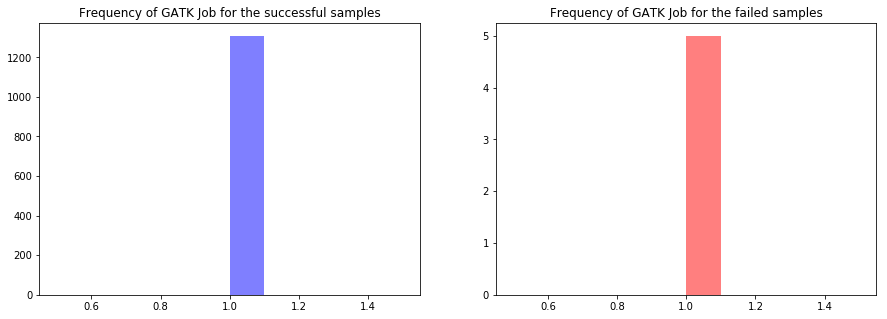

In [308]:
fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(121)
ax1.hist(successful_gatk['numofGATKrun'],color='blue', alpha = 0.5)
ax1.set_title('Frequency of GATK Job for the successful samples')
ax2=fig.add_subplot(122)
ax2.hist(failed_gatk['numofGATKrun'],color='red', alpha = 0.5)
ax2.set_title('Frequency of GATK Job for the failed samples')
plt.show()

#### Running Time

In [348]:
## Relationship check with Running Time and Job Status
query1 = "Match (j:Job:Cromwell) WHERE (j)-[*]->(:Merged:Vcf) RETURN j.durationMinutes AS GatkRunTime"
successful_gatk_run = graph.run(query1).to_data_frame()
#successful_gatk.head(3)

query2 = "Match (j:Job:Cromwell) WHERE not (j)-[*]->(:Merged:Vcf) RETURN j.durationMinutes AS GatkRunTime, j.logging AS log"
failed_gatk_run = graph.run(query2).to_data_frame()


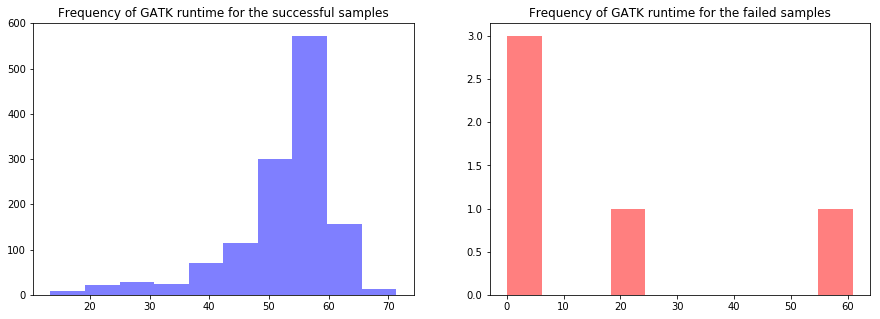

In [345]:
fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(121)
ax1.hist(successful_gatk_run['GatkRunTime']/60,color='blue', alpha = 0.5)
ax1.set_title('Frequency of GATK runtime for the successful samples')
ax2=fig.add_subplot(122)
ax2.hist(failed_gatk_run['GatkRunTime']/60,color='red', alpha = 0.5)
ax2.set_title('Frequency of GATK runtime for the failed samples')
plt.show()

### Outputs without GATK job information

#### VCF without GATK job information

In [325]:
query = "MATCH (v:Merged:Vcf) WHERE not (:Job:Cromwell)-[*]->(v) RETURN v.sample, v.dirname"
dstat_gatk_df = graph.run(query).to_data_frame()
display(dstat_gatk_df)

""


#### Cram without GATK job information

In [329]:
query = "MATCH (v:Cram) WHERE not (:Job:Cromwell)-[*]->(v) RETURN v.sample, v.dirname"
dstat_gatk_df = graph.run(query).to_data_frame()
display(dstat_gatk_df)

""


#### Crai without GATK job information

In [328]:
query = "MATCH (v:Crai) WHERE not (:Job:Cromwell)-[*]->(v) RETURN v.sample, v.dirname"
dstat_gatk_df = graph.run(query).to_data_frame()
display(dstat_gatk_df)

,v.dirname,v.sample
0,DVALABP000432/SHIP5119465/gatk-5-dollar/190923...,SHIP5119465


In [147]:
#for i in unique_dstat_gatk_df['log']:
#    subprocess.check_output('gsutil cp ' + 'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/'+ i + ' gs://gbsc-gcp-project-mvp-test_user-jinasong/wgs35-logs-v053/gatk-failed-withvcf/', shell=True)

### Dstat messages

#### Job and Dstat connection check

In [332]:
query1 = "MATCH (j:Job:Cromwell) WHERE (j)-[:OUTPUT]->(:Merged:Vcf) and (j)-[:STATUS]->(:Dstat) RETURN count(j)"
dstat_gatk_yes = graph.run(query1).to_series()
print("The number of successful gatk jobs with dstat information : " + str(dstat_gatk_yes[0]))

query2 = "MATCH (j:Job:Cromwell) WHERE (j)-[:OUTPUT]->(:Merged:Vcf) and not (j)-[:STATUS]->(:Dstat) RETURN count(j)"
dstat_gatk_no = graph.run(query2).to_series()
print("The number of successful gatk jobs without dstat information : " + str(dstat_gatk_no[0]))

query3 = "MATCH (j:Job:Cromwell) WHERE not (j)-[:OUTPUT]->(:Merged:Vcf) and (j)-[:STATUS]->(:Dstat) RETURN count(j)"
dstat_gatkx_yes = graph.run(query3).to_series()
print("The number of failed gatk jobs with dstat information : " + str(dstat_gatkx_yes[0]))

query4 = "MATCH (j:Job:Cromwell) WHERE not (j)-[:OUTPUT]->(:Merged:Vcf) and not (j)-[:STATUS]->(:Dstat) RETURN count(j)"
dstat_gatkx_no = graph.run(query4).to_series()
print("The number of failed gatk jobs with dstat information : " + str(dstat_gatkx_no[0]))

The number of successful gatk jobs with dstat information : 1307
The number of successful gatk jobs without dstat information : 1
The number of failed gatk jobs with dstat information : 5
The number of failed gatk jobs with dstat information : 0


#### Job and Dstat information miss-matched cases

In [334]:
query1 = "MATCH (j:Job:Cromwell)-[:STATUS]->(s:Dstat) WHERE (j)-[:OUTPUT]->(:Merged:Vcf) AND not s.status = 'SUCCESS' RETURN distinct s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dstat_gatk_yes_df = graph.run(query1).to_data_frame()
display(dstat_gatk_yes_df)

query3 = "MATCH (j:Job:Cromwell)-[:STATUS]->(s:Dstat) WHERE not (j)-[:OUTPUT]->(:Merged:Vcf) AND s.status = 'SUCCESS' RETURN distinct s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dstat_gatkx_yes_df = graph.run(query3).to_data_frame()
display(dstat_gatkx_yes_df)

query33 = "MATCH (j:Job:Cromwell)-[:STATUS]->(s:Dstat) WHERE not (j)-[:OUTPUT]->(:Merged:Vcf) AND not s.status = 'SUCCESS' RETURN distinct s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dstat_gatkx_yes_df3 = graph.run(query33).to_data_frame()
display(dstat_gatkx_yes_df3)

""


""


,DstatId,Message,log,status
0,gatk-2471c--trellis--190923-214936-98,Started running 'user-command',gs://gbsc-gcp-project-mvp-test-from-personalis...,RUNNING
1,gatk-7fdc5--trellis--190923-220410-20,The assigned worker has failed to complete the...,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE
2,gatk-ccc0e--trellis--190923-224120-08,Workflow 467872d3-5a11-4f6d-a25d-f9f90e61b72d ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE
3,gatk-653fd--trellis--190923-230447-78,Workflow e75a10d0-1e1c-4523-840b-982cea8e506c ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE
4,gatk-77604--trellis--190924-015002-59,Workflow 95c7e923-6249-4b25-a269-05984f4069af ...,gs://gbsc-gcp-project-mvp-test-from-personalis...,FAILURE


#### Job and Dstat duplication issue check

In [338]:
query1 = "MATCH (j:Job:Cromwell)-[:STATUS]->(s:Dstat) WHERE (j)-[:OUTPUT]->(:Merged:Vcf) RETURN j.dsubJobId AS gatkID, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dstat_gatk_df = graph.run(query1).to_data_frame()

query2 = "MATCH (j:Job:Cromwell)-[:STATUS]->(s:Dstat) WHERE (j)-[:OUTPUT]->(:Merged:Vcf) RETURN distinct j.dsubJobId AS gatkID, count(s.jobId) AS cnt" #, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message, s.logging AS log"
dup_dstat_gatk_df = graph.run(query2).to_data_frame()
dup=dup_dstat_gatk_df[dup_dstat_gatk_df['cnt']>1]

display(dstat_gatk_df[dstat_gatk_df['gatkID'].isin(dup['gatkID'])])

,DstatId,Message,gatkID,log,status


In [147]:
#for i in unique_dstat_gatk_df['log']:
#    subprocess.check_output('gsutil cp ' + i + ' gs://gbsc-gcp-project-mvp-test_user-jinasong/wgs35-logs-v053/gatk-failed-withvcf/', shell=True)

#### Dstat messages of all failed jobs

In [336]:
# query = "MATCH (j:Job:Cromwell)-[*]->(s:Dstat) \
# WHERE not (j)-[:OUTPUT]->(:Merged:Vcf) RETURN j.plate AS plate, s.logging AS log, \
# j.sample AS sample, s.jobId AS DstatId, s.status AS status, s.statusMessage AS Message"
# dstat_gatk_df = graph.run(query).to_data_frame()
# dstat_gatk_df.head(3)
# unique_dstat_gatk_df=dstat_gatk_df.groupby('DstatId').first()
# unique_dstat_gatk_df.reset_index(inplace=True)
# display(len(unique_dstat_gatk_df))
# display(unique_dstat_gatk_df.groupby(['Message']).count())

### Log file analysis (Failed $5 GATK)

#### The number of log files

In [349]:
failedloglist=list(failed_gatk_run['log'])
f = open("./failed_GATK_log_v053.txt", 'w')
missinglog = 0 
for i in failedloglist:
    try:
        output = str(subprocess.check_output('gsutil ls ' + i, shell=True),'utf-8')
        f.write(output)
    except:
        missinglog += 1
        f.write("Unexpected error:" + i +'\n')
f.close()

print("The number of log of failed jobs : " + str(len(failedloglist)))
print("The number of failed jobs missing log files : " + str(missinglog))

The number of log of failed jobs : 5
The number of failed jobs missing log files : 0


#### log file analysis

In [351]:
fulllog = pd.read_csv('./failed_GATK_log_v053.txt', header=None)
donelog = 0
for i in fulllog[0]:
    if 'stderr' in i:
        try:
            display(i)
            donelog += 1
            display(str(subprocess.check_output('gsutil cat ' + i + '| grep "done"', shell=True),'utf-8'))
        except:
            continue
print("The number of failed jobs with 'stderr' : " + str(donelog))

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000444/SHIP5141905/gatk-5-dollar/190923-220408-500-7fdc5cc5/logs/gatk-7fdc5--trellis--190923-220410-20-stderr.log'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000452/SHIP5165752/gatk-5-dollar/190923-224118-082-ccc0e675/logs/gatk-ccc0e--trellis--190923-224120-08-stderr.log'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000453/SHIP5153220/gatk-5-dollar/190923-230446-247-653fddd5/logs/gatk-653fd--trellis--190923-230447-78-stderr.log'

'gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000461/SHIP5169309/gatk-5-dollar/190924-015000-890-77604662/logs/gatk-77604--trellis--190924-015002-59-stderr.log'

The number of failed jobs with 'stderr' : 4


In [147]:
#for i in unique_dstat_gatk_df['log']:
#    subprocess.check_output('gsutil cp ' + i + ' gs://gbsc-gcp-project-mvp-test_user-jinasong/wgs35-logs-v053/gatk-failed-withvcf/', shell=True)